In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
connection = engine.connect()


In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [10]:
#   Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
# Calculate the date 1 year ago from the last data point in the database
first_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(first_date)

# Query the last 12 months of precipitation scores and sort by date
date_filter = Measurement.date >= '2016-08-23'

last_year = session.query(Measurement.date, Measurement.prcp).filter(date_filter).order_by(Measurement.date).all()

last_year_date = [date[0] for date in last_year]
last_year_prcp = [prcp[1] for prcp in last_year]

# Save the query results as a Pandas DataFrame, drop the rows with missing values, and set the index to the date column
last_year_prcp_df = pd.DataFrame({"Date": last_year_date,
                                  "Precipitation": last_year_prcp
                                 })
#drop rows with missing values
last_year_prcp_df = last_year_prcp_df.dropna()
#convert date from sting to datetime
last_year_prcp_df['Date'] = pd.to_datetime(last_year_prcp_df['Date'])
#se index to Date
last_year_prcp_df = last_year_prcp_df.set_index("Date")
# Display the dataframe
last_year_prcp_df


('2017-08-23',)
2016-08-23


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


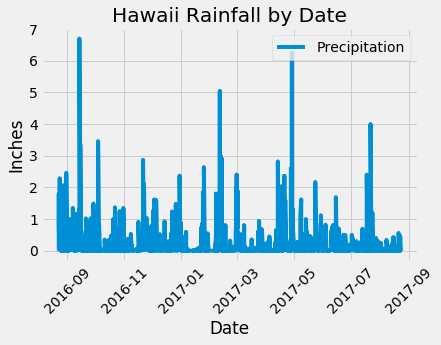

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(last_year_prcp_df.index,last_year_prcp_df["Precipitation"], label="Precipitation")
plt.xticks( rotation="45")
plt.title("Hawaii Rainfall by Date")
plt.legend(loc="upper right")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#create dataframe to display the mean, median, variance, standard deviation, and SEM of the Precipitation
summary_stats_df = pd.DataFrame({"Summary Statistic": ["Precipitation Mean", "Precipitation Median", "Precipitation Variance", "Precipitation Stnd Deviation", "Precipitation SEM"],
                                 "Precipitation in Inches": [last_year_prcp_df["Precipitation"].mean(),
                                                        last_year_prcp_df["Precipitation"].median(),
                                                        last_year_prcp_df["Precipitation"].var(),
                                                        last_year_prcp_df["Precipitation"].std(),
                                                        last_year_prcp_df["Precipitation"].sem()]
                                })
#Display the summary statistics table
summary_stats_df = summary_stats_df.set_index("Summary Statistic")
summary_stats_df


,Precipitation in Inches
Summary Statistic,
Precipitation Mean,0.177279
Precipitation Median,0.020000
Precipitation Variance,0.212696
Precipitation Stnd Deviation,0.461190
Precipitation SEM,0.010259


In [24]:
# Design a query to show how many stations are available in this dataset?
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the observation counts in descending order.

session.query((Measurement.station), func.count(Measurement.station).label('station_count')).\
    group_by(Measurement.station).\
    order_by(desc('station_count')).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Using the most active station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the last 12 months within the database
station_filter = Measurement.station == 'USC00519281'

temp_results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(station_filter).filter(date_filter).all()

min_t= [temp[0] for temp in temp_results]
min_t= min_t[0]

max_t= [temp[1] for temp in temp_results]
max_t= max_t[0]

avg_t= [temp[2] for temp in temp_results]
avg_t= round(avg_t[0],2)

temp_stats_df = pd.DataFrame({"Temperature Statistic": ["Lowest temperature", "Highest temperature", "Average temperature"],
                                 "Temperature in (F)": [min_t, max_t, avg_t]
                                })
temp_stats_df


,Temperature Statistic,Temperature in (F)
0,Lowest temperature,59.00
1,Highest temperature,83.00
2,Average temperature,73.11


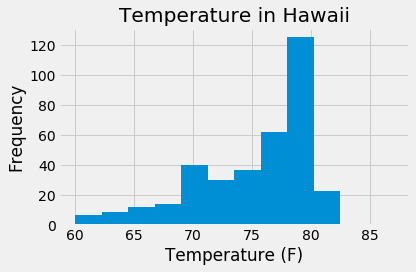

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_list = []


last_year_temp = session.query(Measurement.tobs).filter(station_filter).filter(date_filter).all()
for temps in last_year_temp:
    temp_list.append(temps[0])

plt.hist(temp_list, 12)
plt.title('Temperature in Hawaii')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('hi', 'hello'))

[(None, None, None)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`



#session.close()
